In [174]:
import uproot
import glob
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [175]:
df = []
for baby in glob.glob("output/ttbar-monolep-tautology_*"):
    df.append(((uproot.open(baby)).get("tree")).pandas.df())
df = pd.concat(df)

In [176]:
df.columns

Index([u'event', u'met', u'weight', u'error', u'flav_weight', u'flav_error',
       u'lepton_id', u'lepton_pt', u'lepton_eta', u'lepton_is_loose',
       u'lepton_is_tight', u'fake_id', u'fake_pt', u'fake_pt_corr',
       u'fake_eta', u'fake_gen_match', u'fake_is_loose', u'fake_is_tight',
       u'fake_unmatched', u'fake_from_b', u'fake_from_c', u'fake_from_light',
       u'n_jets', u'n_btags_deepCSV_loose', u'n_btags_deepCSV_medium',
       u'n_btags_deepCSV_tight', u'n_btags_deepJet_loose',
       u'n_btags_deepJet_medium', u'n_btags_deepJet_tight'],
      dtype='object')

# 1. Derivation
Using the single-lepton $t\bar{t}$ MC, we made babies by the following recipe:
1. Loop over all reco leptons and ensure that the event has _exactly_ one electron that passes the loose selection and _exactly_ one muon that passes the loose selection
2. Truth match the electron or muon to the actual prompt lepton of the event ($\implies$ the other lepton is fake)
3. Require that the prompt lepton passes the tight selection
4. Pass the fake lepton through the loose and tight selections and store the results of both

## 1.1 Data

In [177]:
fr_df = df.filter(regex=("fake_*")).copy()

print(fr_df.columns)

el_fr_df = fr_df[fr_df.fake_id.abs() == 11]
mu_fr_df = fr_df[fr_df.fake_id.abs() == 13]

Index([u'fake_id', u'fake_pt', u'fake_pt_corr', u'fake_eta', u'fake_gen_match',
       u'fake_is_loose', u'fake_is_tight', u'fake_unmatched', u'fake_from_b',
       u'fake_from_c', u'fake_from_light'],
      dtype='object')


## 1.2 Binning

In [178]:
el_pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
el_eta_bin_edges = np.array([0,0.8,1.47,2.5])
el_bin_edges = np.array([el_pt_bin_edges, el_eta_bin_edges])

mu_pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
mu_eta_bin_edges = np.array([0,1.2,2.1,2.4])
mu_bin_edges = np.array([mu_pt_bin_edges, mu_eta_bin_edges])

## 1.3 Utilities
Copy-pasting code across Jupyter notebooks is disgraceful, perhaps, but necessary for now.

In [179]:
def fake_rate_table(fake_rate, pt_bin_edges, eta_bin_edges, name="", outfile=None, writemode="w"):
    if not name:
        name = "fakeRate"
    cpp = "\nfloat "+name+"(float pt, float eta) {\n"
    for i in range(fake_rate.shape[1]):
        for j in range(fake_rate.shape[0]):
            edges = []
            # Low pt bin
            edges.append("pt >= {:.3f}".format(pt_bin_edges[i]))
            if i < fake_rate.shape[1]-1:
                # High pt bin
                edges.append("pt < {:.3f}".format(pt_bin_edges[i+1]))
            if j < fake_rate.shape[0]:
                # Low eta bin
                edges.append("fabs(eta) >= {:.3f}".format(eta_bin_edges[j]))            
                # High eta bin
                edges.append("fabs(eta) < {:.3f}".format(eta_bin_edges[j+1]))
            # Add if statement
            cpp += "    if ({0}) return {1:0.3f};\n".format(" && ".join(edges), fake_rate[j,i])
    # Add default return
    cpp += "    return 0.0;\n"
    # Wrap up function      
    cpp += "}\n"
    # Print code
    print(cpp)
    # Write code
    if outfile:
        with open(outfile, writemode) as fout:
            fout.write(cpp)
            
    return

def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, size=8, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

def clopper_pearson_error(passed, total, level=0.6827):
    """Matching TEfficiency::ClopperPearson()
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """

    alpha = 0.5 * (1.0 - level)
    low = scipy.stats.beta.ppf(alpha, passed, total - passed + 1)
    high = scipy.stats.beta.ppf(1 - alpha, passed + 1, total - passed)
    return low, high

def fake_rate_errors(fake_rate, tight_counts, loose_counts):
    """ Calculate errors for N_tight/N_loose
    """
    bothzero = (tight_counts == 0) & (loose_counts == 0)
    err_down, err_up = clopper_pearson_error(tight_counts, loose_counts)
    # these are actually the positions for down and up, but we want the errors
    # wrt to the central value
    err_up = err_up - fake_rate.T
    err_down = fake_rate.T - err_down
    errors = 0.5*(err_down + err_up)  # nominal errors are avg of up and down
    errors[np.isnan(errors)] = 0.0 # avoid NaN entries
    # For consistency with TEfficiency, up error is 1 if we have 0/0
    err_up[bothzero] = 1.0
    
    return errors, err_up, err_down

def fake_rate_2D(df, pt_bin_edges, eta_bin_edges, pt_overflow=True, eta_overflow=False,
                 plot=True, fig=None, axes=None):
    # Get cone-corrected pt values
    loose_fake_pt_corr = df[df.fake_is_loose].fake_pt_corr
    tight_fake_pt_corr = df[df.fake_is_tight].fake_pt_corr
    if pt_overflow:
        loose_fake_pt_corr = np.clip(loose_fake_pt_corr, pt_bin_edges[0], 
                                pt_bin_edges[-1])
        tight_fake_pt_corr = np.clip(tight_fake_pt_corr, pt_bin_edges[0], 
                                pt_bin_edges[-1])
    # Get eta values
    loose_fake_eta = df[df.fake_is_loose].fake_eta.abs()
    tight_fake_eta = df[df.fake_is_tight].fake_eta.abs()
    if eta_overflow:
        loose_fake_eta = np.clip(loose_fake_eta, eta_bin_edges[0], eta_bin_edges[-1])
        tight_fake_eta = np.clip(tight_fake_eta, eta_bin_edges[0], eta_bin_edges[-1])
    # Collect bin edges
    bin_edges = np.array([pt_bin_edges, eta_bin_edges])
    # Count loose fakes
    loose_counts, _, _ = np.histogram2d(loose_fake_pt_corr, loose_fake_eta, 
                                        bins=bin_edges)
    # Count tight fakes
    tight_counts, _, _ = np.histogram2d(tight_fake_pt_corr, tight_fake_eta, 
                                        bins=bin_edges)
    # Divide them
    fake_rate = np.divide(tight_counts.T, loose_counts.T, 
                          where=(loose_counts.T != 0))
    fake_rate[loose_counts.T == 0] = 0
    # Plot
    if plot:
        if not fig or not axes:
            fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
            axes = plt.subplot(111)
        c = axes.pcolorfast(pt_bin_edges, eta_bin_edges, fake_rate)
        cbar = fig.colorbar(c, ax=axes)
        bin_text(fake_rate, pt_bin_edges, eta_bin_edges, axes, cbar, 
                 size=12, fmt=":0.2f");
        # Format plot
        plt.xlabel(r'$p_{T}$', size=18);
        plt.ylabel(r'$|\eta|$', size=18);
        plt.xticks(pt_bin_edges, size=12);
        plt.yticks(eta_bin_edges, size=12);
    # Calculate errors
    errors, _, _ = fake_rate_errors(fake_rate, tight_counts, loose_counts)
    
    return fake_rate, errors.T

def fake_rate_1D(loose_pts, tight_pts, label="", fmt="rs",
                 fig=None, axes=None, overflow=True):
    # Set up figure
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4,6.4))
        axes = plt.subplot(111)
    # Define bins
    pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
    if overflow:
        loose_pts = np.clip(loose_pts, pt_bin_edges[0], pt_bin_edges[-1])
        tight_pts = np.clip(tight_pts, pt_bin_edges[0], pt_bin_edges[-1])
    # Get histogram values
    loose_counts, _ = np.histogram(loose_pts, bins=pt_bin_edges)
    tight_counts, _ = np.histogram(tight_pts, bins=pt_bin_edges)
    fake_rate = np.divide(1.0*tight_counts, loose_counts, 
                          where=(loose_counts != 0))
    fake_rate[loose_counts == 0] = 0
    bin_widths = pt_bin_edges[1:]-pt_bin_edges[:-1]
    bin_centers = pt_bin_edges[:-1]+0.5*bin_widths
    # Get errors
    errors, _, _ = fake_rate_errors(fake_rate, tight_counts, loose_counts)
    # Plot error bars
    axes.errorbar(bin_centers, fake_rate, xerr=0.5*bin_widths, yerr=errors,
                  fmt=fmt, label=label);
    plt.ylim([0,0.6])
    axes.margins(0) # Remove axis margins
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    
    return bin_centers

## 1.4 Plots

### 1.4.1 Electrons

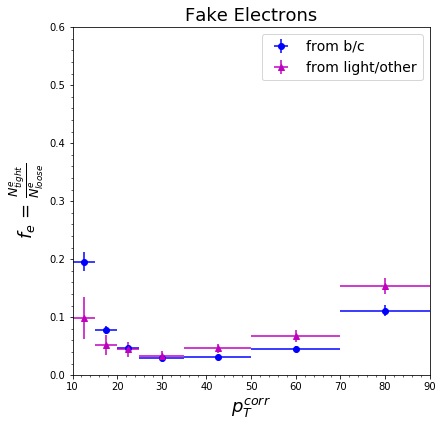

In [180]:
fig = plt.figure(figsize=(6.4,6.4))
axes = plt.subplot(111)

fake_el_from_heavy = (el_fr_df.fake_from_b | el_fr_df.fake_from_c)
fake_el_from_light = (el_fr_df.fake_from_light | el_fr_df.fake_unmatched)

fake_rate_1D(el_fr_df[el_fr_df.fake_is_loose & fake_el_from_heavy].fake_pt_corr, 
             el_fr_df[el_fr_df.fake_is_tight & fake_el_from_heavy].fake_pt_corr,
             fig=fig, axes=axes, fmt="bo", label="from b/c");

fake_rate_1D(el_fr_df[el_fr_df.fake_is_loose & fake_el_from_light].fake_pt_corr, 
             el_fr_df[el_fr_df.fake_is_tight & fake_el_from_light].fake_pt_corr,
             fig=fig, axes=axes, fmt="m^", label="from light/other");

plt.xlabel(r"$p_{T}^{corr}$", size=18)
plt.ylabel(r"$f_{e}$ = $\frac{N_{tight}^{e}}{N_{loose}^{e}}$", size=18);
plt.title("Fake Electrons", size=18);

plt.legend(fontsize=14);

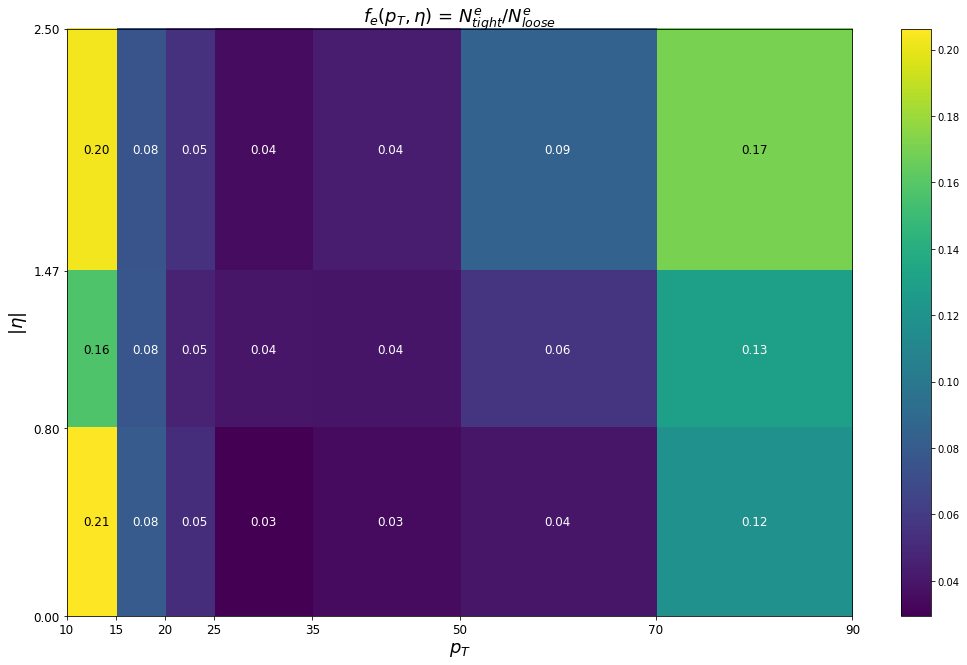

In [181]:
el_fr, el_fr_err = fake_rate_2D(el_fr_df, el_pt_bin_edges, el_eta_bin_edges);

plt.title(r'$f_{e}(p_{T},\eta)$ = $N_{tight}^{e}$/$N_{loose}^{e}$', size=18);

In [182]:
fake_rate_table(el_fr, el_pt_bin_edges, el_eta_bin_edges, name="electronFakeRate", 
                outfile="utilities/electrons.C", writemode="w")


float electronFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.206;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.158;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.203;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.080;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.077;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.076;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.053;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.046;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.055;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.029;
    if (pt >=

In [183]:
fake_rate_table(el_fr_err, el_pt_bin_edges, el_eta_bin_edges, name="electronFakeRateError", 
                outfile="utilities/electrons.C", writemode="a")


float electronFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.023;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.024;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.034;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.010;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.012;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.014;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.007;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.008;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.011;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.004;
    if (

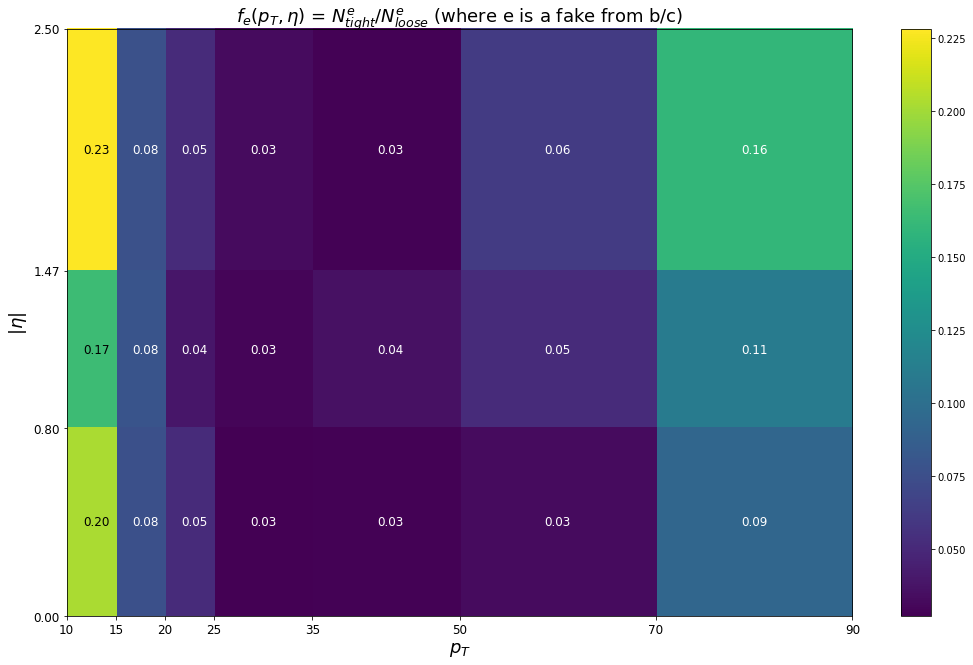

In [184]:
el_heavy_fr, el_heavy_fr_err = fake_rate_2D(el_fr_df[fake_el_from_heavy], 
                                            el_pt_bin_edges, el_eta_bin_edges);

plt.title(r'$f_{e}(p_{T},\eta)$ = $N_{tight}^{e}$/$N_{loose}^{e}$ (where e is a fake from b/c)', size=18);

In [185]:
fake_rate_table(el_heavy_fr, el_pt_bin_edges, el_eta_bin_edges, name="electronHeavyFakeRate", 
                outfile="utilities/electrons.C", writemode="a")


float electronHeavyFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.203;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.165;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.228;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.076;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.080;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.077;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.051;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.039;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.052;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.027;
    if (

In [186]:
fake_rate_table(el_heavy_fr_err, el_pt_bin_edges, el_eta_bin_edges, name="electronHeavyFakeRateError", 
                outfile="utilities/electrons.C", writemode="a")


float electronHeavyFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.024;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.027;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.041;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.011;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.014;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.017;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.008;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.009;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.013;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.004;
   

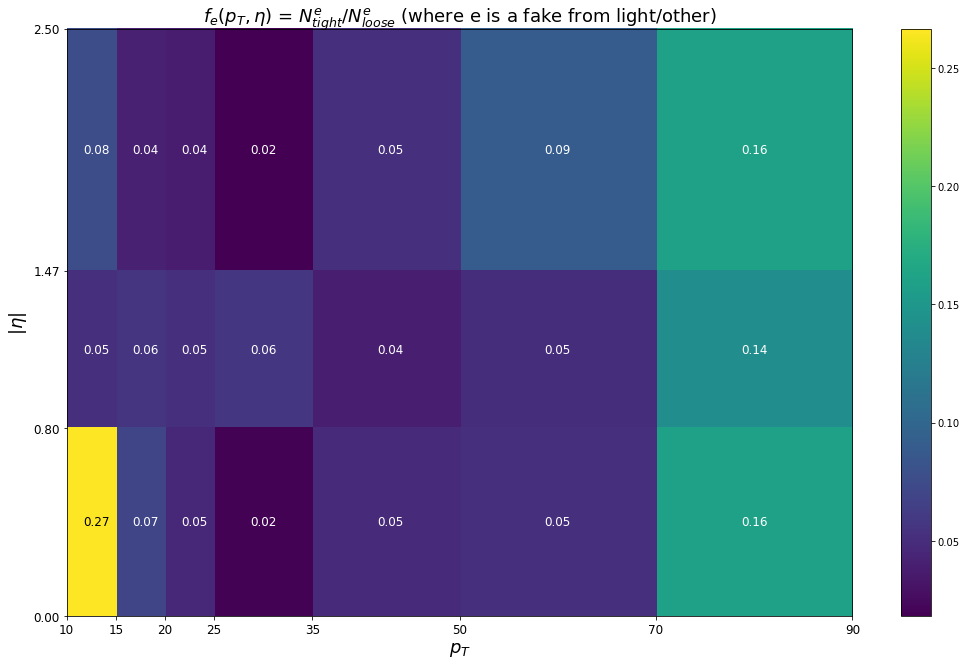

In [187]:
el_light_fr, el_light_fr_err = fake_rate_2D(el_fr_df[fake_el_from_light], 
                                            el_pt_bin_edges, el_eta_bin_edges);

plt.title(r'$f_{e}(p_{T},\eta)$ = $N_{tight}^{e}$/$N_{loose}^{e}$ (where e is a fake from light/other)', 
          size=18);

In [188]:
fake_rate_table(el_light_fr, el_pt_bin_edges, el_eta_bin_edges, name="electronLightFakeRate", 
                outfile="utilities/electrons.C", writemode="a")


float electronLightFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.267;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.053;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.077;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.070;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.056;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.041;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.046;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.053;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.037;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.020;
    if (

In [189]:
fake_rate_table(el_light_fr_err, el_pt_bin_edges, el_eta_bin_edges, name="electronLightFakeRateError", 
                outfile="utilities/electrons.C", writemode="a")


float electronLightFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.142;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.050;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.055;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.050;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.035;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.025;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.034;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.800 && fabs(eta) < 1.470) return 0.025;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.470 && fabs(eta) < 2.500) return 0.020;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 0.800) return 0.015;
   

### 1.4.2 Muons

16350 fake muons from b/c
354 fake muons from light/other


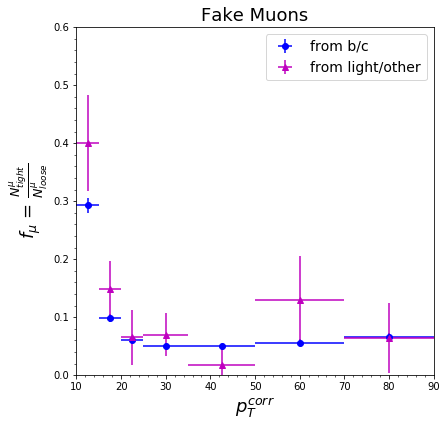

In [190]:
fig = plt.figure(figsize=(6.4,6.4))
axes = plt.subplot(111)

fake_mu_from_heavy = (mu_fr_df.fake_from_b | mu_fr_df.fake_from_c)
fake_mu_from_light = (mu_fr_df.fake_from_light | mu_fr_df.fake_unmatched)

fake_rate_1D(mu_fr_df[mu_fr_df.fake_is_loose & fake_mu_from_heavy].fake_pt_corr, 
             mu_fr_df[mu_fr_df.fake_is_tight & fake_mu_from_heavy].fake_pt_corr,
             fig=fig, axes=axes, fmt="bo", label="from b/c");

fake_rate_1D(mu_fr_df[mu_fr_df.fake_is_loose & fake_mu_from_light].fake_pt_corr, 
             mu_fr_df[mu_fr_df.fake_is_tight & fake_mu_from_light].fake_pt_corr,
             fig=fig, axes=axes, fmt="m^", label="from light/other");

plt.xlabel(r"$p_{T}^{corr}$", size=18)
plt.ylabel(r"$f_{\mu}$ = $\frac{N_{tight}^{\mu}}{N_{loose}^{\mu}}$", size=18);
plt.title("Fake Muons", size=18);

plt.legend(fontsize=14);

print("{} fake muons from b/c".format(np.sum(fake_mu_from_heavy)))
print("{} fake muons from light/other".format(np.sum(fake_mu_from_light)))

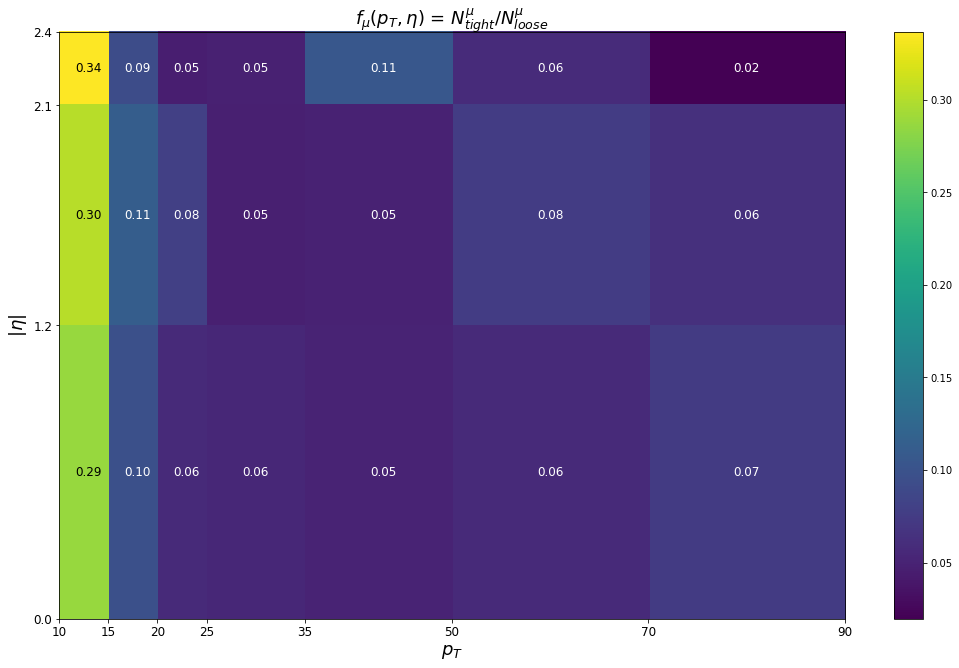

In [191]:
mu_fr, mu_fr_err = fake_rate_2D(mu_fr_df, mu_pt_bin_edges, mu_eta_bin_edges);

plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$', size=18);

In [192]:
fake_rate_table(mu_fr, mu_pt_bin_edges, mu_eta_bin_edges, name="muonFakeRate", 
                outfile="utilities/muons.C", writemode="w")


float muonFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.287;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.302;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.337;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.097;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.113;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.094;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.057;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.079;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.046;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.055;
    if (pt >= 25.

In [193]:
fake_rate_table(mu_fr_err, mu_pt_bin_edges, mu_eta_bin_edges, name="muonFakeRateError", 
                outfile="utilities/muons.C", writemode="a")


float muonFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.016;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.024;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.052;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.008;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.013;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.025;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.006;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.010;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.019;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.005;
    if (pt >

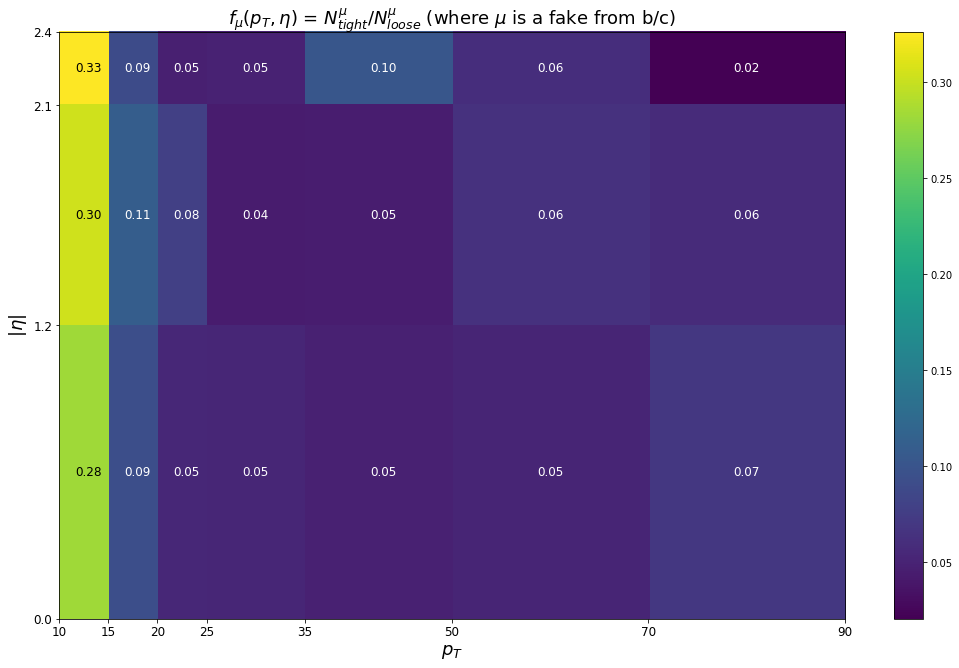

In [194]:
mu_heavy_fr, mu_heavy_fr_err = fake_rate_2D(mu_fr_df[fake_mu_from_heavy], 
                                            mu_pt_bin_edges, mu_eta_bin_edges);

plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$ (where $\mu$ is a fake from b/c)', size=18);

In [195]:
fake_rate_table(mu_heavy_fr, mu_pt_bin_edges, mu_eta_bin_edges, name="muonHeavyFakeRate", 
                outfile="utilities/muons.C", writemode="a")


float muonHeavyFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.283;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.304;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.326;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.094;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.110;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.090;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.054;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.078;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.047;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.053;
    if (pt >

In [196]:
fake_rate_table(mu_heavy_fr_err, mu_pt_bin_edges, mu_eta_bin_edges, name="muonHeavyFakeRateError", 
                outfile="utilities/muons.C", writemode="a")


float muonHeavyFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.017;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.024;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.053;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.008;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.013;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.025;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.006;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.010;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.019;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.005;
    if 

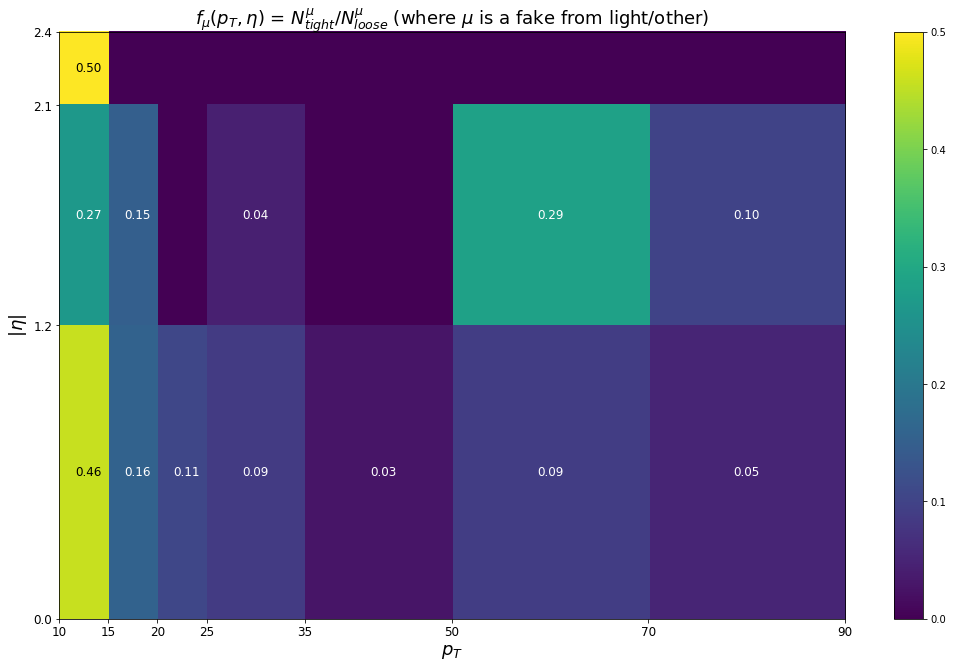

In [197]:
mu_light_fr, mu_light_fr_err = fake_rate_2D(mu_fr_df[fake_mu_from_light], 
                                            mu_pt_bin_edges, mu_eta_bin_edges);

plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$ (where $\mu$ is a fake from light/other)', 
          size=18);

In [198]:
fake_rate_table(mu_light_fr, mu_pt_bin_edges, mu_eta_bin_edges, name="muonLightFakeRate", 
                outfile="utilities/muons.C", writemode="a")


float muonLightFakeRate(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.458;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.267;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.500;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.158;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.152;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.000;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.107;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.000;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.000;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.087;
    if (pt >

In [199]:
fake_rate_table(mu_light_fr_err, mu_pt_bin_edges, mu_eta_bin_edges, name="muonLightFakeRateError", 
                outfile="utilities/muons.C", writemode="a")


float muonLightFakeRateError(float pt, float eta) {
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.120;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.142;
    if (pt >= 10.000 && pt < 15.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.257;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.072;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.077;
    if (pt >= 15.000 && pt < 20.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.000;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.076;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 1.200 && fabs(eta) < 2.100) return 0.000;
    if (pt >= 20.000 && pt < 25.000 && fabs(eta) >= 2.100 && fabs(eta) < 2.400) return 0.000;
    if (pt >= 25.000 && pt < 35.000 && fabs(eta) >= 0.000 && fabs(eta) < 1.200) return 0.052;
    if 

# 2. Closure
Now, we re-run our babymaker with a slightly modified recipe:
1. Loop over all reco leptons and ensure that the event has _exactly_ one electron that passes the loose selection and _exactly_ one muon that passes the loose selection
2. Truth match the electron or muon to the actual prompt lepton of the event ($\implies$ the other lepton is fake)
3. Require that the prompt lepton passes the tight selection
4. Check if the fake lepton passes the tight selection
    - if it passes tight, classify event as TT
    - if it fails tight, classify event as TL and weigh event by $f/(1-f)$ where $f = f(p_{T}^{corr}), \eta)$

In [200]:
df = []
for baby in glob.glob("output/ttbar-monolep-tautology_*"):
    df.append(((uproot.open(baby)).get("tree")).pandas.df())
df = pd.concat(df)

In [201]:
df.columns

Index([u'event', u'met', u'weight', u'error', u'flav_weight', u'flav_error',
       u'lepton_id', u'lepton_pt', u'lepton_eta', u'lepton_is_loose',
       u'lepton_is_tight', u'fake_id', u'fake_pt', u'fake_pt_corr',
       u'fake_eta', u'fake_gen_match', u'fake_is_loose', u'fake_is_tight',
       u'fake_unmatched', u'fake_from_b', u'fake_from_c', u'fake_from_light',
       u'n_jets', u'n_btags_deepCSV_loose', u'n_btags_deepCSV_medium',
       u'n_btags_deepCSV_tight', u'n_btags_deepJet_loose',
       u'n_btags_deepJet_medium', u'n_btags_deepJet_tight'],
      dtype='object')

## 2.1 Utilities

In [202]:
def fr_bin_lines(axes, fr_pt_bin_edges):
    for i, bin_edge in enumerate(fr_pt_bin_edges):
        label = ""
        if i == 0:
            label = "FR bin edges"
        axes.axvline(x=bin_edge, color="k", linestyle="--", alpha=0.5, linewidth=0.75,
                     label=label)
        
    return

def ratio_plot(numer, denom, bin_edges, numer_err=None, denom_err=None,
               xerr=0, yerr=0, axes=None, label="", fmt="ko", 
               markersize=3):
    # Get bin dimensions
    bin_widths = bin_edges[1:]-bin_edges[:-1]
    bin_centers = bin_edges[:-1]+0.5*bin_widths
    # Aviod divide-by-zero
    denom[denom == 0] = 10^(-8)
    # Get ratios
    ratios = 1.0*numer/denom
    # Get errors on ratio
    if not yerr:
        bothzero = (numer == 0) & (denom == 0)
        err_down, err_up = clopper_pearson_error(numer, denom)
        # these are actually the positions for down and up, but we want the errors
        # wrt to the central value
        err_up = err_up - ratios
        err_down = ratios - err_down
        errors = 0.5*(err_down + err_up)  # nominal errors are avg of up and down
        # For consistency with TEfficiency, up error is 1 if we have 0/0
        err_up[bothzero] = 1.0
        yerr = errors
    # Plot ratios
    axes.errorbar(bin_centers, ratios, xerr=xerr, yerr=yerr, 
                  fmt=fmt, label=label, markersize=markersize);
    # Get relative errors
    if not type(numer_err) == type(None) and not type(denom_err) == type(None):
        rel_errors = (
            (numer_err/denom)**2.0 + (denom_err*numer/denom**2.0)**2.0
        )**0.5
        # Plot relative errors
        err_points = np.repeat(bin_edges, 2)[1:-1]
        err_high = np.repeat(1+rel_errors, 2)
        err_low = np.repeat(1-rel_errors, 2)
        axes.fill_between(err_points, err_high, err_low, 
                          step="mid", hatch="///////", facecolor="none",
                          edgecolor=(0.75,0.75,0.75), linewidth=0.0, linestyle='-',
                          zorder=2)
    # Formatting
    axes.margins(x=0) # Remove axis margins
    
    return

def errorbar_hist(vals, weights=None, bins=None, yerr=None, fmt="ko", 
                  label="", markersize=4, fig=None, axes=None):
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4,4.8))
        axes = plt.subplot(111)
    # Get histogram values
    counts, bin_edges = np.histogram(vals, weights=weights, bins=bins)
    # Get bin dimensions
    bin_widths = bin_edges[1:]-bin_edges[:-1]
    bin_centers = bin_edges[:-1]+0.5*bin_widths
    # Plot error bars
    axes.errorbar(bin_centers, counts, yerr=yerr, fmt=fmt, label=label,
                  markersize=markersize);
    
    return counts, bin_edges
    
def closure_hist(df, variable, overflow=True, bins=None, title=""):
    # Set up figure
    fig = plt.figure(figsize=(6.4*1.5,4.8*1.25*1.5))
    gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2,0.65],
                           hspace=0.05)
    
    # --> Kinematics hist <-- #
    axes = fig.add_subplot(gs[0])
    # Selections
    TT = (df.lepton_is_tight & df.fake_is_tight)
    TL = (df.lepton_is_tight & (df.fake_is_loose & ~df.fake_is_tight))
    # Plot truth
    TT_values = df[TT][variable]
    if overflow:
        TT_values = np.clip(TT_values, bins[0], bins[-1])
    TT_counts, _, _ = plt.hist(TT_values, bins=bins, 
                               label=r"$t\bar{{t}}$ $(TT)$ [{0}]".format(np.sum(TT)),
                               color='yellow', histtype='stepfilled', edgecolor='k',
                               zorder=1)
    # Truth errors
    TT_err = np.sqrt(TT_counts)
    err_points = np.repeat(bins, 2)[1:-1]
    err_high = np.repeat(TT_counts+TT_err, 2)
    err_low = np.repeat(TT_counts-TT_err, 2)
    axes.fill_between(err_points, err_high, err_low, 
                      step="mid", hatch="///////", facecolor="none",
                      edgecolor=(0.75,0.75,0.75), linewidth=0.0, linestyle='-',
                      zorder=2)
    
    # Plot prediction
    TL_values = df[TL][variable]
    TL_weights = df[TL].weight
    if overflow:
        TL_values = np.clip(TL_values, bins[0], bins[-1])
    TL_err_counts, _ = np.histogram(TL_values, weights=TL_weights**2.0, 
                                    bins=bins)
    TL_err = np.sqrt(TL_err_counts)
    TL_counts, _ = errorbar_hist(TL_values, bins=bins,
                                 weights=TL_weights, yerr=TL_err,
                                 label=r"Prediction ($TL\rightarrow TT$) [{:.1f}]".format(np.sum(TL*df.weight)), 
                                 fig=fig, axes=axes)
    # Formatting
    plt.ylim(bottom=0)
    plt.legend(fontsize=12);
    plt.ylabel("Events", size=18)
    axes.margins(x=0) # Remove axis margins
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    if (bins.shape[0] > 10):
        plt.xticks(bins[::4])
    plt.xticks(size=14)
    plt.yticks(size=14)
    axes.tick_params(labelbottom=False)
    axes.margins(x=0) # Remove axis margins
    plt.title(title, size=18)
    axes.text(0.0, 1.01,"CMS", horizontalalignment="left", verticalalignment="bottom", 
              transform=axes.transAxes, weight="bold", size=18)
    axes.text(0.09, 1.01, "Tautology", horizontalalignment="left", verticalalignment="bottom", 
              transform=axes.transAxes, style="italic", size=18)
    
    # --> Ratio plot <-- #
    axes = fig.add_subplot(gs[1])
    ratio_plot(TL_counts, TT_counts, bins, numer_err=TT_err, denom_err=TL_err, 
               axes=axes);
    axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
    # Formatting
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    if (bins.shape[0] > 10):
        plt.xticks(bins[::4])
    plt.ylabel(r"$\frac{TL\rightarrow TT}{TT}$", size=18)
    plt.ylim([0.5,1.5])
    plt.xlim([bins[0], bins[-1]])
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    return fig

## 2.2 Plots

### 2.2.1 Prompt lepton $p_T$

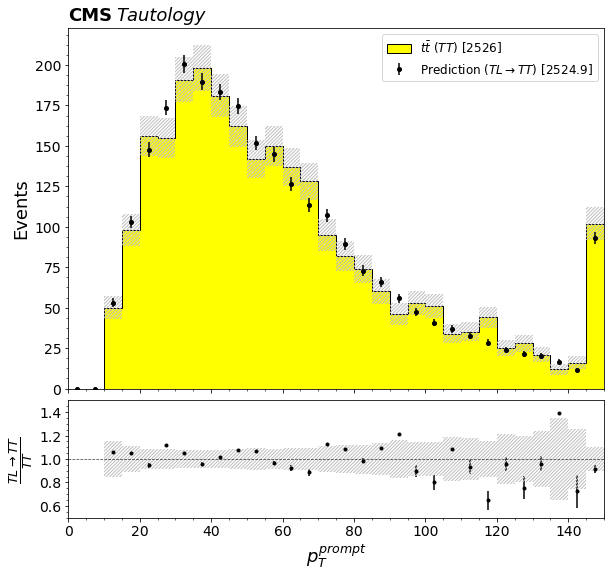

In [203]:
closure_hist(df, "lepton_pt", bins=np.linspace(0,150,31));
plt.xlabel(r"$p_{T}^{prompt}$", size=18);

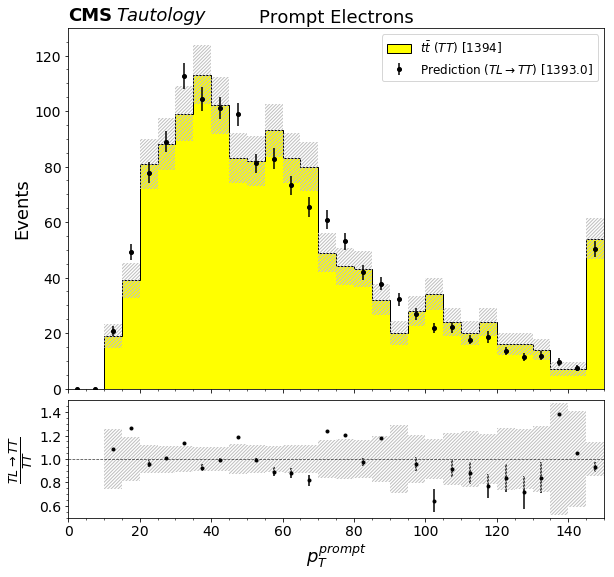

In [204]:
closure_hist(df[df.lepton_id.abs() == 11], "lepton_pt", bins=np.linspace(0,150,31),
             title="Prompt Electrons");
plt.xlabel(r"$p_{T}^{prompt}$", size=18);

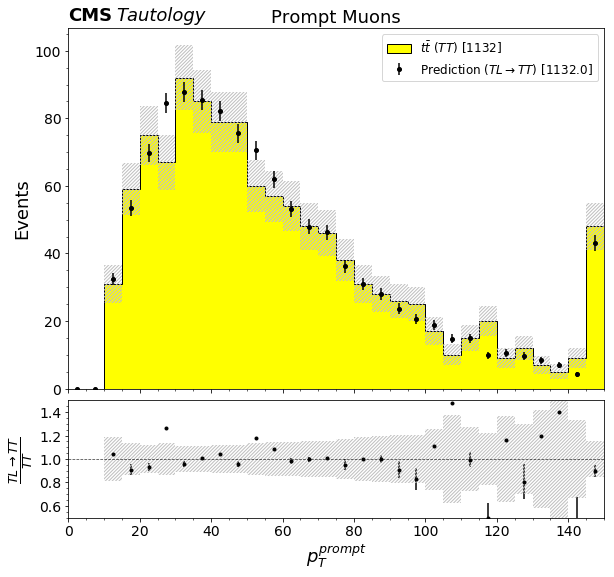

In [205]:
closure_hist(df[df.lepton_id.abs() == 13], "lepton_pt", bins=np.linspace(0,150,31),
             title="Prompt Muons");
plt.xlabel(r"$p_{T}^{prompt}$", size=18);

### 2.2.2 Fake lepton $p_T$

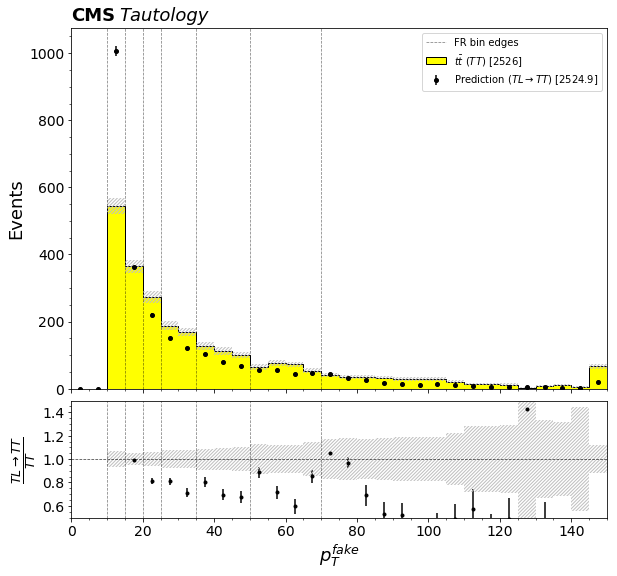

In [219]:
fig = closure_hist(df, "fake_pt", bins=np.linspace(0,150,31));
plt.xlabel(r"$p_{T}^{fake}$", size=18);

hist_axes, ratio_axes = fig.get_axes();
fr_bin_lines(hist_axes, el_pt_bin_edges[:-1]) # el and mu pt bins are the same
hist_axes.legend();
fr_bin_lines(ratio_axes, el_pt_bin_edges[:-1]) # el and mu pt bins are the same

### 2.2.3 Fake lepton $p_{T}^{corr}$

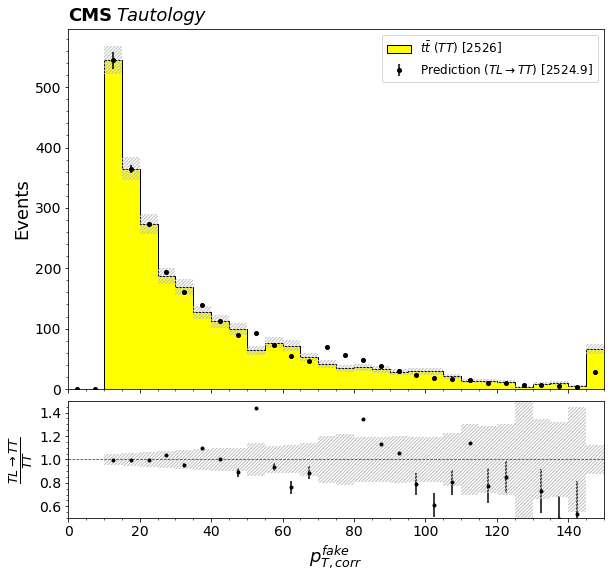

In [207]:
closure_hist(df, "fake_pt_corr", bins=np.linspace(0,150,31));
plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

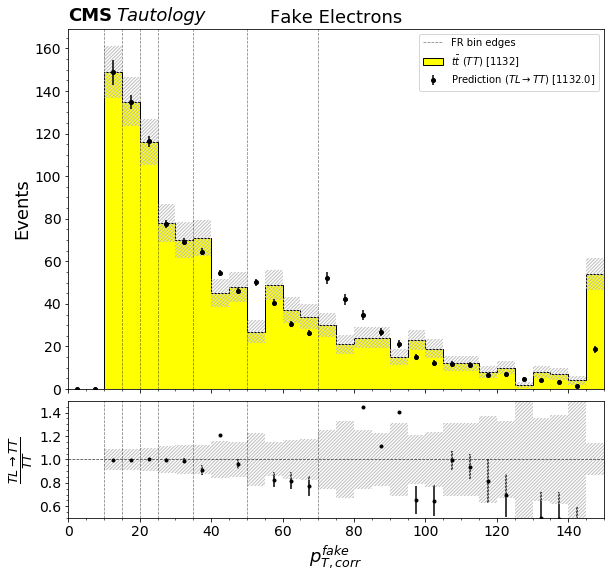

In [208]:
fig = closure_hist(df[df.fake_id.abs() == 11], "fake_pt_corr", bins=np.linspace(0,150,31),
                   title="Fake Electrons");
plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

hist_axes, ratio_axes = fig.get_axes();
fr_bin_lines(hist_axes, el_pt_bin_edges[:-1])
hist_axes.legend();
fr_bin_lines(ratio_axes, el_pt_bin_edges[:-1])

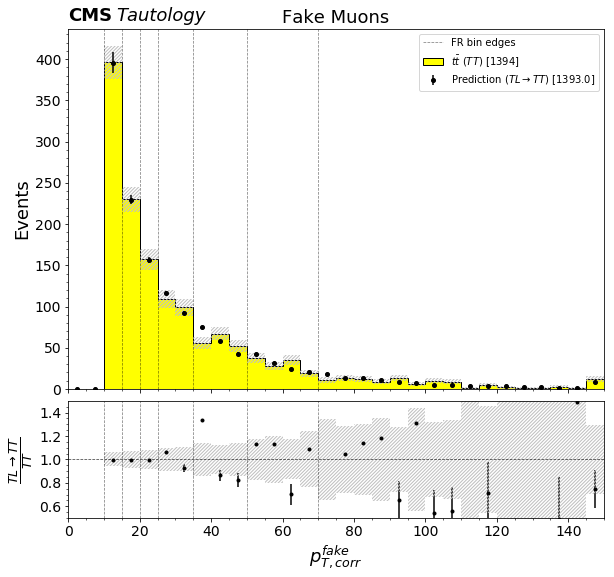

In [209]:
fig = closure_hist(df[df.fake_id.abs() == 13], "fake_pt_corr", bins=np.linspace(0,150,31),
                   title="Fake Muons");
plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

hist_axes, ratio_axes = fig.get_axes();
fr_bin_lines(hist_axes, mu_pt_bin_edges[:-1])
hist_axes.legend();
fr_bin_lines(ratio_axes, mu_pt_bin_edges[:-1])

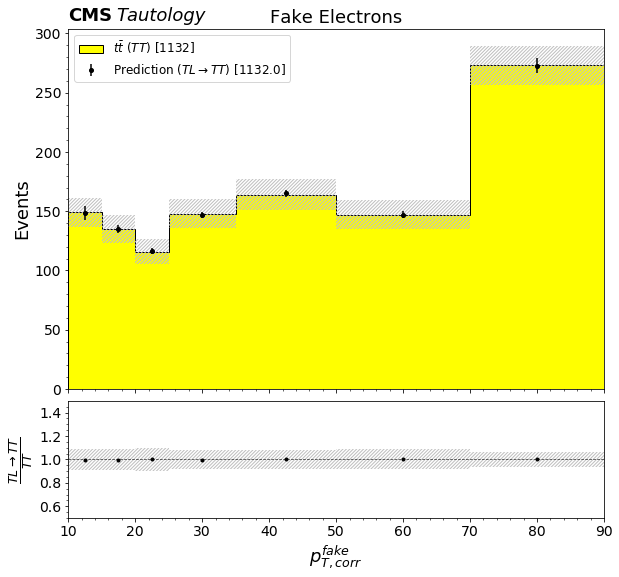

In [210]:
closure_hist(df[df.fake_id.abs() == 11], "fake_pt_corr", bins=el_pt_bin_edges,
             title=r"Fake Electrons");

plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

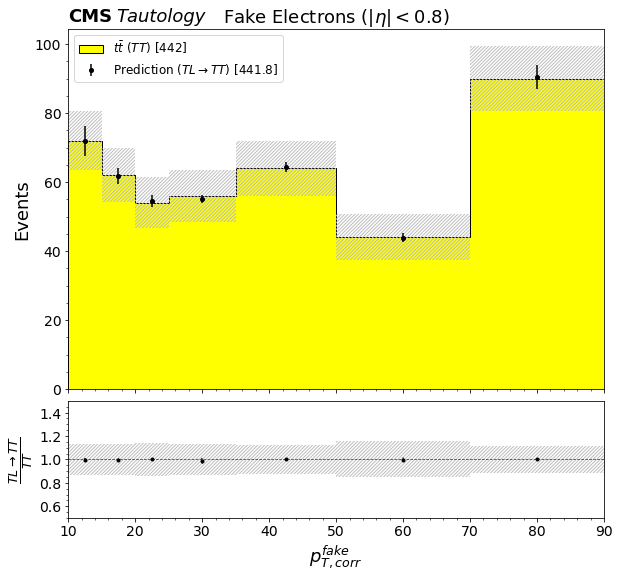

In [211]:
closure_hist(df[(df.fake_id.abs() == 11) & (df.fake_eta.abs() < el_eta_bin_edges[1])], 
             "fake_pt_corr", bins=el_pt_bin_edges, title=r"Fake Electrons $(|\eta| < 0.8)$");

plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

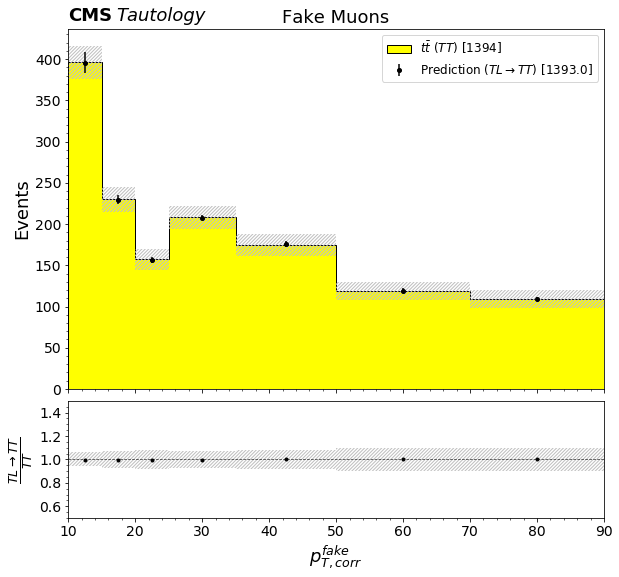

In [212]:
closure_hist(df[df.fake_id.abs() == 13], "fake_pt_corr", bins=el_pt_bin_edges,
             title=r"Fake Muons");

plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

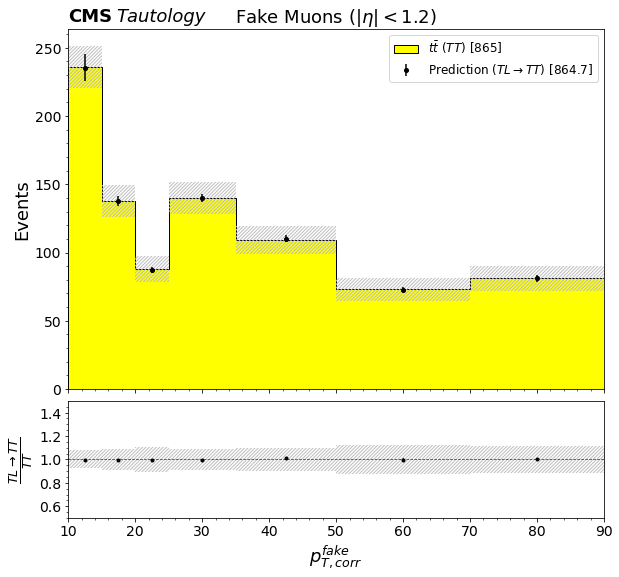

In [213]:
closure_hist(df[(df.fake_id.abs() == 13) & (df.fake_eta.abs() < mu_eta_bin_edges[1])], 
             "fake_pt_corr", bins=el_pt_bin_edges, title=r"Fake Muons $(|\eta| < 1.2)$");

plt.xlabel(r"$p_{T,corr}^{fake}$", size=18);

### 2.2.4 Number of b-tags (DeepJet tight)

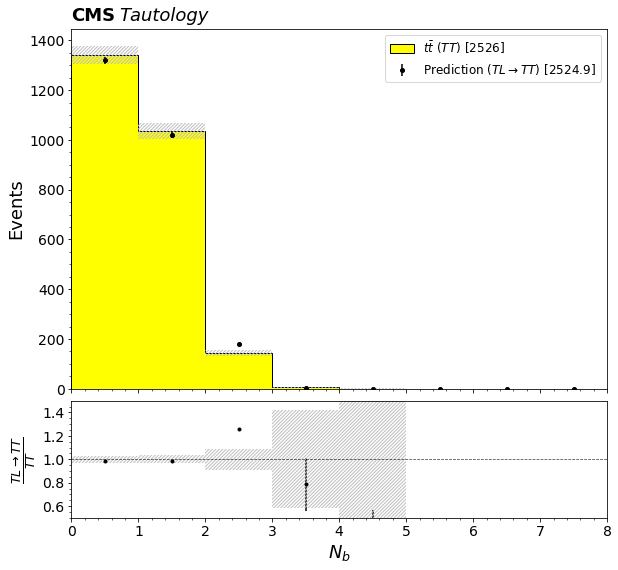

In [214]:
closure_hist(df, "n_btags_deepJet_tight", bins=np.linspace(0,8,9));
plt.xlabel(r"$N_{b}$", size=18);

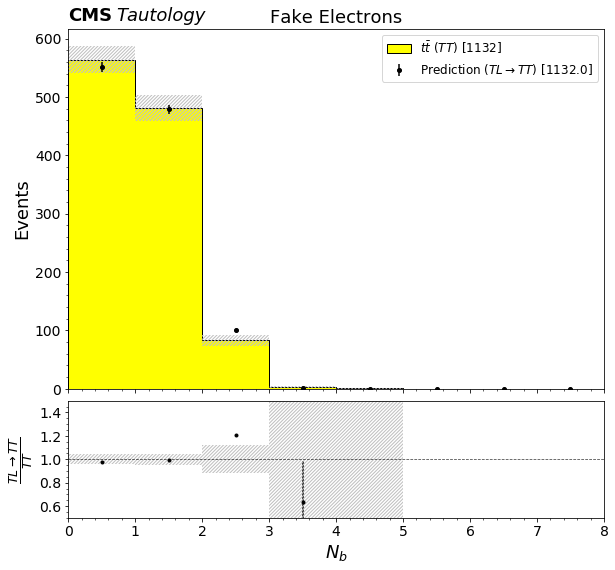

In [215]:
closure_hist(df[df.fake_id.abs() == 11], "n_btags_deepJet_tight", bins=np.linspace(0,8,9),
             title=r"Fake Electrons");
plt.xlabel(r"$N_{b}$", size=18);

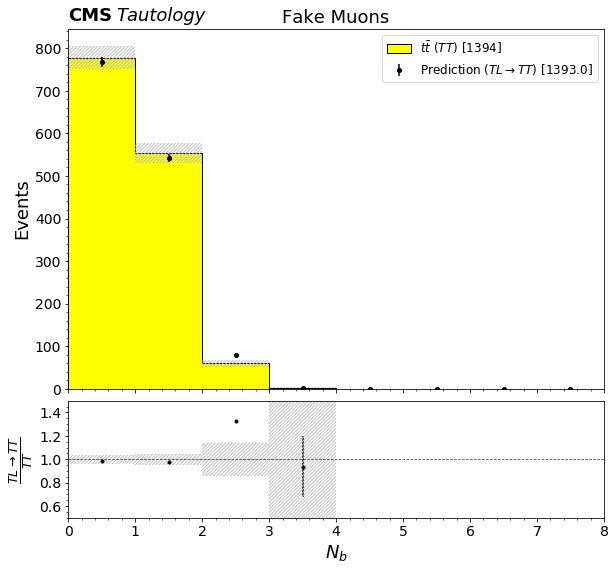

In [216]:
closure_hist(df[df.fake_id.abs() == 13], "n_btags_deepJet_tight", bins=np.linspace(0,8,9),
             title=r"Fake Muons");
plt.xlabel(r"$N_{b}$", size=18);

### 2.2.5 Number of jets

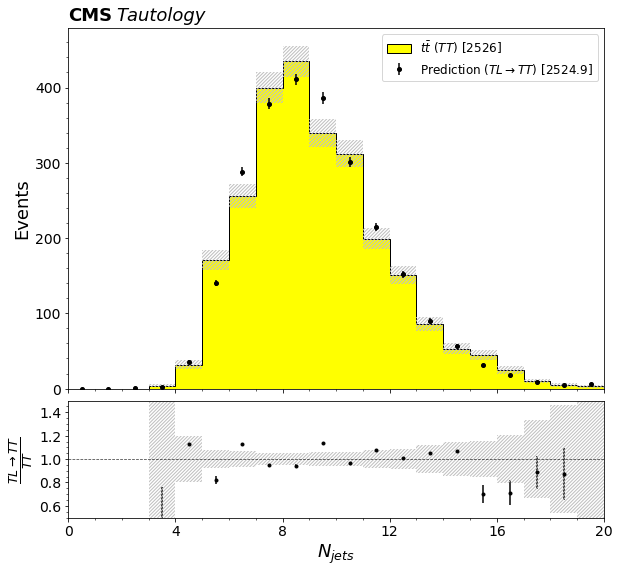

In [217]:
closure_hist(df, "n_jets", bins=np.linspace(0,20,21));
plt.xlabel(r"$N_{jets}$", size=18);

### 2.2.6 MET

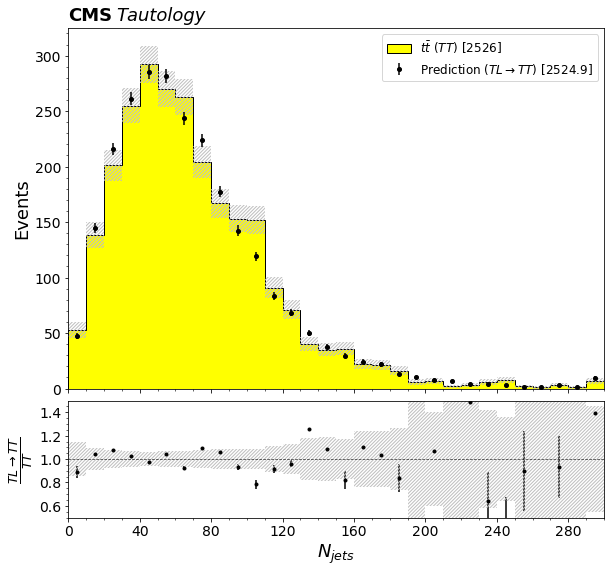

In [218]:
closure_hist(df, "met", bins=np.linspace(0,300,31));
plt.xlabel(r"$N_{jets}$", size=18);